Rafał Nowak
# Numerical Optimization
## Problem set 2 (14 points)

**Submission deadline**: Thursday, 12.11.2020

* All submissions should contain single file.<br/>This can be single Jupyter notebook file (with extension `ipynb`) or ZIP archive in case the are some additional files needed.
* It is recommended to write the reports using LaTeX. 
* One can report the answers, comments and results in PDF or notebook file.
* All the source code should be written in Python or Julia.

**Problem 2.1 (5 pts)**

In the problem 1.3, your implementation may have done a lot of inverse operations.

This task is to implement *revised simplex algorithm* with incremental A inverse computation 
by using the **[Sherman-Morrison](https://www.wikiwand.com/en/Sherman%E2%80%93Morrison_formula)** formula for keeping track of the inverse matrix.

Your program will be graded based on how fast it is.
You should expect to see a factor 10-20 speedup depending on the problem instance.

def revised_simplex_method(I, c, A, b):
    while True:
        
    return(v,x)

In [8]:
# B = [1,1  1,2  1,3
#      2,1, 2,2  2,3
#      3,1  3,2  3,3]
# say I changes from [1,2,3] to [1,5,3]
# ie. column of index 1 in B changes values from column 2 in A to column 5 in A 
# B' =  [1,1  1,5  1,3
#       2,1,  2,5  2,3
#       3,1   3,5  3,3]
# B' = B + u @ v.T
# therefore
# u @ v.T = [0  1,5-1,2  0
#            0  2,5-2,2  0
#            0  3,5-3,2  0]
# v = [0  1  0].T --> len(B) zero vector with entry 1 at the index of changed column in B' (here at 1)
# u = [1,5-1,2  2,5-2,2  3,5-3,2] --> len(B) vector of differences between values from new column - old
# column in B' and B respectively - (here column 5 from A - column 2 from A)
# now B'^-1 = (B + u @ v.T)^-1 = B^-1 - (B^-1 @ u @ v.T @ B^-1) / (1 + v.T @ B^-1 @ u)

In [9]:
import numpy as np

def revised_simplex_method(I, c, A, b):
    
    Ab = np.hstack((A, b.reshape(len(b), 1)))
    I_bar = [i for i in range(A.shape[1]) if i not in I] 
    # initial inverse from numpy
    B = A[:,I]
    B_inverse = np.linalg.inv(B) 
    while True:
        
        B_inverse_Ab = B_inverse @ Ab
        
        # find c_b and c_n   
        c_b = c[I]
        c_n = c[I_bar]
        
        # get B_inv_N from B_inv_Ab
        B_inverse_N = B_inverse_Ab[:,I_bar]
        
        # r has the same length as I_bar
        r = (c_n -  c_b.T @ B_inverse_N)
        
        # condition for breaking the loop    
        if np.all(r >= 0):
            x = np.zeros(A.shape[1])
            x[I] = B_inverse_Ab[:,-1] #solution to the LP
            val = c.T @ x #calculate the minimized value
            return (val, x)
        
        # get index of the most negative r element
        h_index = np.argmin(r)
        # column number under that index in I_bar going into I
        column_in = I_bar[h_index]
        # get ratios of x_b and column going in
        # ratios has the same length as I
        ratios = B_inverse_Ab[:, -1] / B_inverse_Ab[:, column_in]
        # want smallest positive ratio - replace negatives with a very big number
        v_index = np.where(ratios > 0, ratios, 10000).argmin()
        # column number under that v_index in I going into I_bar
        column_out = I[v_index]
        # swap columns
        I[v_index], I_bar[h_index] = column_in, column_out
        
        # define vectors u and v
        u = np.array(A[:, column_in] - A[:, column_out]).reshape(-1,1)
        v = np.zeros(len(u)).reshape(-1,1)
        v[v_index] = 1
        # update new inverse using previous with Sherman-Morrison formula
        B_inverse = B_inverse - (B_inverse @ u @ v.T @ B_inverse) / (1 + v.T @ B_inverse @ u)

In [12]:
# get normal simplex from Lab 1 to compare the time efficiency

def simplex_method(I, c, A, b):
    '''
    Function implementing a simplex algorith to solve a LPP defined by:
    - c: the objective function to be minimized
    - A and b: matrix and vector forming a set of constraints so that Ax = b
    - I: a list of integers indicating column indices which form the initial basis
        
    Outputs a tuple containing:
    - v: the minimized value of the objective function
    - x: np.array with the solution to the LP
    '''
    card = len(I) # cardinality of set I
    x = np.zeros(A.shape[1])
    Ab = np.hstack((A, b.reshape(len(b), 1)))    
    I_bar = [i for i in range(A.shape[1]) if i not in I] 
        
    while True:
        B = A[:,I]
        B_inverse = np.linalg.inv(B) 
        
        B_inverse_Ab = B_inverse @ Ab
        
        # find c_b and c_n   
        c_b = c[I]
        c_n = c[I_bar]
        
        # get B_inv_N from B_inv_Ab
        B_inverse_N = B_inverse_Ab[:,I_bar]
        
        # r has the same length as I_bar!
        r = (c_n -  c_b.T @ B_inverse_N)
        
        # condition for breaking the loop    
        if np.all(r >= 0):
            x = np.zeros(A.shape[1])
            x[I] = B_inverse_Ab[:,-1] #solution to the LP
            val = c.T @ x #calculate the minimized value
            return (val, x)
        
        # get index of the most negative r element
        h_index = np.argmin(r)
        # column number under that index in I_bar going into I
        column_in = I_bar[h_index]
        # get ratios of x_b and column going in
        # ratios has the same length as I!
        ratios = B_inverse_Ab[:, -1] / B_inverse_Ab[:, column_in]
        # want smallest positive ratio - replace negatives with a very big number
        v_index = np.where(ratios > 0, ratios, 10000).argmin()
        # column number under that v_index in I going into I_bar
        column_out = I[v_index]
        # swap columns
        I[v_index], I_bar[h_index] = column_in, column_out

In [14]:
# now compare time elapsed to solve all LPPs from the file for revised and normal simplexes

import time

data = np.load('simplex_test_data.npz', allow_pickle = True)['data'].item()

start = time.time()
for i in range(1,41,1):
    simplex_method(data[i]['I'],data[i]['c'],data[i]['A'],data[i]['b'])[0]
end = time.time()

start_rev = time.time()
for i in range(1,41,1):
    revised_simplex_method(data[i]['I'],data[i]['c'],data[i]['A'],data[i]['b'])[0]
end_rev = time.time()

print(f"Time elapsed for normal simplex: {end - start}")
print(f"Time elapsed for revised simplex: {end_rev - start_rev}")

Time elapsed for normal simplex: 0.1485896110534668
Time elapsed for revised simplex: 0.015738725662231445


*Hint*. Please test your code with attached `npz` file (see problem 1.3).<br/>
Repeat the tests with `method = revised_simplex_method` and compare the time elapsed for both methods.

---

In [15]:
# get the solve function from Lab 1 to use

def solve(A,b):
    '''
    Finds the solution to the matrix equation Ax = b for provided A and b
    Input:
    - A; square nxn matrix
    - b; n-dimensional vector
    Returns:
    - x; n-dimensional vector
    '''
    
    M = np.hstack((A,b))
    M = M.astype(np.float32)
    
    #bring matrix to echelon form
    for i in range(0, len(A)):
        for j in range(1, len(A)):
            if j > i:
                M[j] = M[j] - (M[j, i] / M[i, i]) * M[i] 
                
    #get one in the last [n,n] marix entry
    M[-1] = M[-1] / M[A.shape[0] - 1, A.shape[1] - 1]
    
    #go backwards to obtain an n x n Identity        
    for i in range(len(A)-1, -1, -1):
        for j in range(len(A)-2, -1, -1):
            
            #row operations to get zero values on off-diagonals
            if i > j:
                M[j] = M[j] - M[j,i] * M[i] 
                
            #obtaining ones on the diagonals    
            if i == j:
                M[j] = M[j] / M[j,j]
                
    return M[:,-1].reshape(len(b),1)

**Problem 2.2 (6 pts)**

Assume have a~set of $N$ noisy measurements $(x_i, \tilde y_i)\in\mathbb R^2$ onto which we would like to to fit a line $y=ax+b$. This task can be expressed by the following optimization problem in $L_2$ norm:
$$ \min_{a,b} \sum_{i=1}^N \left(a x_i + b - \tilde y_i\right)^2 = \min_{a,b} \left\| J \begin{pmatrix}a\\b\end{pmatrix} - \tilde y \right\|_2^2,$$
where $\|\cdot\|_2$ means the $L_2$ norm.

One can check that the optimal solution can be obtained by solving the linear system
$$ J^T J \begin{pmatrix}a\\b\end{pmatrix} = J^T \tilde y. $$

* (1 pt) Generate the problem data. Take $N=30, 50, 100$ points in the interval $[0,5]$ and generate the true outputs $y_i = a x_i + b$ for some $a,b\in\R$; for example take $a=3, b=4$. Add Gaussian noise $~N(0,1)$ to get the noisy measurements $\tilde y_i$ and plot the results.
* (3 pts) Compute the matrix $J$ and solve the problem using your implementation of Gaussian elimination (see problem 1.1). Plot the obtained line in the same graph as the measurements. 
* (2 pts) Next use any implementation (like `np.linalg.solve`) instead of your Gaussian elimination. Compare the resulting const function values.
* (1 pt) Finally, add some outliers to the data and plot the results (single graph with measurements and solution line).

In [ ]:
# J is an N x 2 matrix s.t. (N, 2) @ (2, 1) = (N,1) to match noisy vector y_tilda 
# first column is just the N-dim vector with entries x_i and second column is full of ones to account for the 
# constant b being added to ax_i

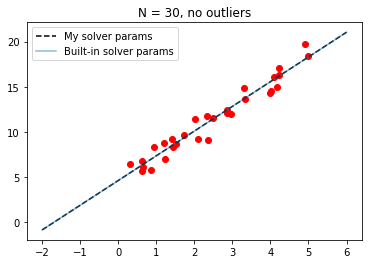

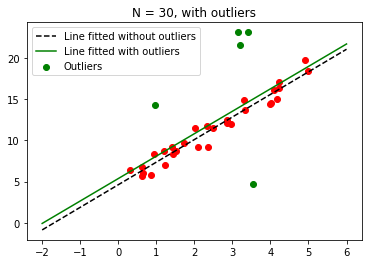

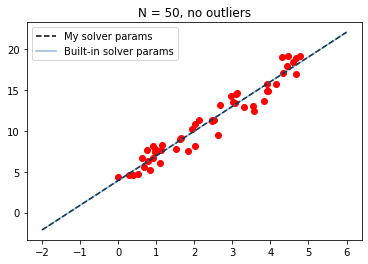

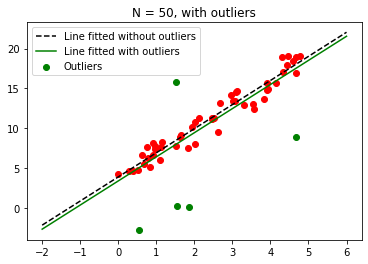

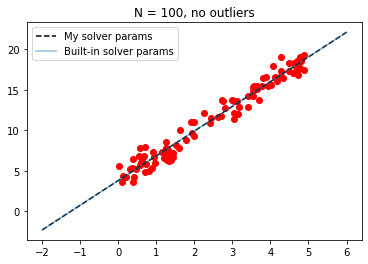

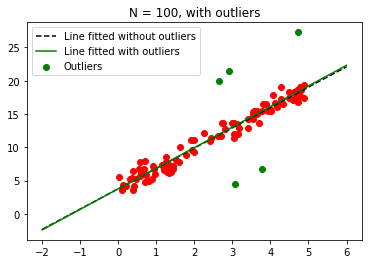

In [16]:
import numpy as np
import matplotlib.pyplot as plt
N = [30, 50, 100]
a = 3
b = 4

data = {}

for n in N:
    # generate data
    x = np.random.uniform(low = 0, high = 5, size = (n, 1))
    y_true = a * x + b
    y_noisy = y_true + np.random.randn(n).reshape(-1,1)
    
    # addition of outliers
    outliers_x = np.random.uniform(low = 0, high = 5, size = (5, 1))
    outliers_y = a * outliers_x + b
    outliers_y = [i + np.random.choice([-1, 1]) * \
                  np.random.uniform(low = 7, high = 10, size = 1) for i in  outliers_y]   
    
    # save the data for the next question
    data[n] = {'x':x, 'y_noisy':y_noisy, 
               'outliers_x':outliers_x, 'outliers_y':np.array(outliers_y)}
    
    #compute matrix J without outliers
    J = np.hstack((x, np.ones(shape = (len(x), 1))))
    mat = J.T @ J
    vec = J.T @ y_noisy
    
    #compute matrix J with outliers
    row = np.hstack((outliers_x, np.ones(shape = (len(outliers_x), 1))))
    y_noisy_out = np.vstack((y_noisy, outliers_y))
    J_out = np.vstack((J, row))
    mat_out = J_out.T @ J_out
    vec_out = J_out.T @ y_noisy_out
    
    #solve to get parameters without outliers
    fitted_params = solve(mat, vec)
    built_in_solver_params = np.linalg.solve(mat, vec)
    
    #solve to get parameters with outliers
    fitted_params_out = solve(mat_out, vec_out)
    
    #fitted lines without outliers
    support = np.linspace(-2,6,100)
    my_line = fitted_params[0] * support + fitted_params[1]
    solver_line = built_in_solver_params[0] * support + built_in_solver_params[1]
    
    #fitted lines with outliers
    out_line = fitted_params_out[0] * support + fitted_params_out[1]
    
    plt.figure()
    plt.scatter(x, y_noisy, c='r')
    plt.plot(support, my_line, 'k', label = 'My solver params', ls = '--')
    plt.plot(support, solver_line, label = 'Built-in solver params', alpha = 0.5)
    plt.legend()
    plt.title(f'N = {n}, no outliers')
    plt.show
    
    plt.figure()
    plt.scatter(outliers_x, outliers_y, c='green', label = 'Outliers')
    plt.scatter(x, y_noisy, c='r')
    plt.plot(support, my_line, 'k', label = 'Line fitted without outliers', ls = '--')
    plt.plot(support, out_line, c='green', label = 'Line fitted with outliers')
    plt.legend()
    plt.title(f'N = {n}, with outliers')
    plt.show


In [21]:
# looking at the graphs and parameters it seems that the fit line obtained from my solver coincides 
# with the best fit line obtained using the numpy np.linalg.solve solver

---

**Problem 2.3 (3 pts)**

In this problem you are going to fit a line to the set of measurements, but this time with $L_1$ norm, i.e.
$$ \min_{a,b} \sum_{i=1}^{N} |a x_i + b - y_i|. $$
which is not diffentiable. Use some slack variables $s_1, s_2, \ldots, s_N$ and reformulate the problem
into the form
$$
\begin{alignat}{2}
                   & \min_{a,b,s} \sum_i s_i,\\
\text{s.t.} \qquad & -s_i \leq ax_i+b-y_i \leq s_i, \qquad & i=1,2,\ldots, N,\\
                   & s_i \geq 0,                           & i=1,2,\ldots, N.
\end{alignat}
$$

* Solve the problem using the measurements generated in the previous exercise (both with and without outliers)
* You can use any LP solver (recommended Gurobi).

Remark. You can get 3 extra points if you use your implementation of Simplex method and obtain similar results. Test your method not only with $a=3, b=4$.

In [22]:
# have 2N double inequality constraints 

In [26]:
for n in N:
    c = abs(a * data[n]['x'] + b - data[n]['y_noisy'])
